In [2]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [3]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0 or row[2].find('normal') >= 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:740e:e:e0e:,grid_1gh70-7_2019-02-19_23:11_,177,465.497175,36520.160503,191.102487,5,234.0,1399.0,0.115,10,GH
1,aaaa::212:7406:6:606:,grid_1gh70-7_2019-02-19_23:11_,182,255.192308,19384.134084,139.226916,3,136.0,958.0,0.090,11,GH
2,aaaa::212:7407:7:707:,grid_1gh70-7_2019-02-19_23:11_,165,265.400000,22517.204878,150.057339,2,101.0,1103.0,0.175,8,GH
3,aaaa::212:740d:d:d0d:,grid_1gh70-7_2019-02-19_23:11_,164,488.432927,58540.934124,241.952339,4,200.0,1359.0,0.180,6,GH
4,aaaa::212:7410:10:1010:,grid_1gh70-7_2019-02-19_23:11_,141,499.375887,73331.050557,270.797065,4,225.0,1521.0,0.295,8,GH


Stats for single network

In [4]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,BH,0.23,0.305,0.240,0.215,0.190,0.100,0.170,0.240,0.200,0.220,0.255,0.275,0.170,0.080,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,BH,0.07,0.160,0.010,0.025,0.045,0.015,0.130,0.075,0.250,0.125,0.205,0.100,0.040,0.210,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,GH,0.48,0.350,0.705,0.705,0.825,0.475,0.235,0.550,0.635,0.335,0.425,0.380,0.885,0.455,6.950000e-01,8.900000e-01
3,grid_1gh30-9_2019-02-20_00:12_,GH,0.22,0.180,0.060,0.220,0.115,0.790,0.120,0.760,0.065,0.180,0.155,0.155,0.125,0.105,7.000000e-02,3.200000e-01
4,grid_1gh50-7_2019-02-19_22:53_,GH,0.27,0.650,0.625,0.580,0.145,0.300,0.315,0.360,0.160,0.170,0.165,0.205,0.170,0.345,3.000000e-01,3.500000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

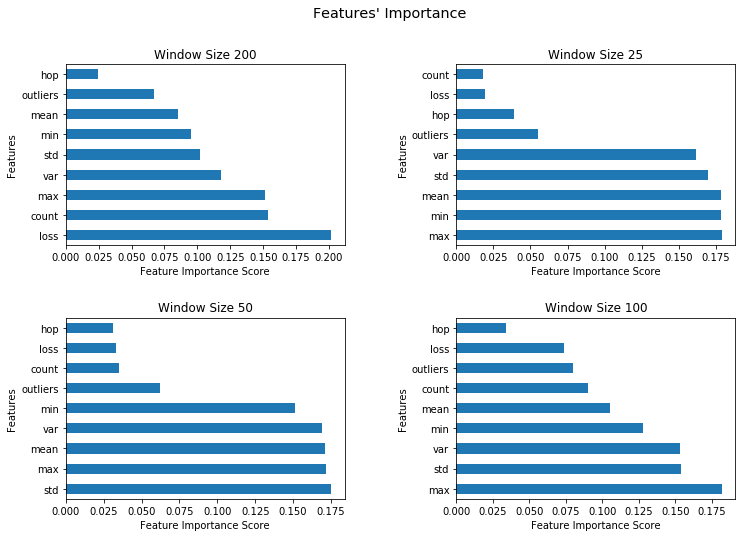

In [5]:
plots_analysis.random_forests_features_selection(trace_stats)

In [6]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [7]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [8]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [9]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [10]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

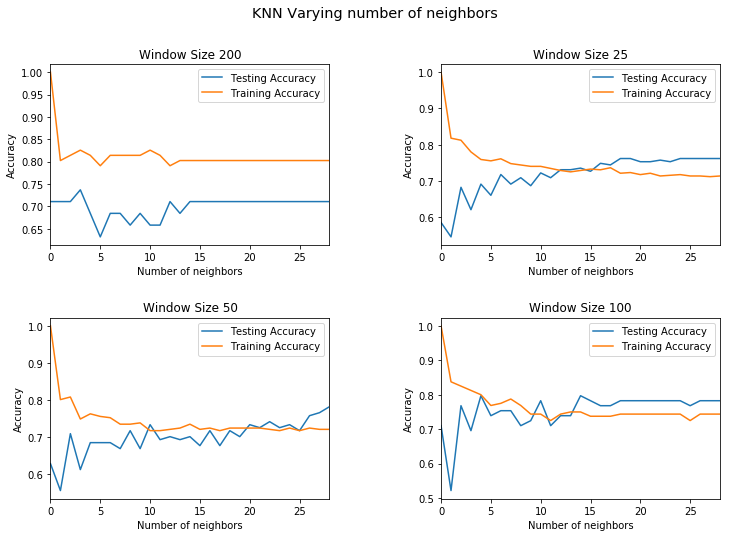

In [11]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [12]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [13]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [14]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [15]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [16]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [17]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [18]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [19]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [20]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=10)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [21]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])
                    

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [22]:
'''
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])
'''

'\nnet_results = pd.concat([net_results, \n                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)\n                    ])\n'

Cross validation

In [23]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# Per Node Results
Results from each model

In [24]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.710526,0.625000,0.580808,0.583250,0.164175,0.021924
1,Random Forest,25,0.682819,0.505832,0.504446,0.501099,0.296555,0.014369
2,Random Forest,50,0.709677,0.530398,0.521577,0.519587,0.213501,0.024703
3,Random Forest,100,0.739130,0.490625,0.496296,0.473729,0.163983,0.016460
4,KNN,200,0.710526,0.355263,0.500000,0.415385,0.001561,0.003364
5,KNN,25,0.748899,0.465686,0.495066,0.444797,0.013314,0.014062
6,KNN,50,0.717742,0.380342,0.463542,0.417840,0.001501,0.006322
7,KNN,100,0.768116,0.389706,0.490741,0.434426,0.001370,0.005605
8,SVM,200,0.684211,0.351351,0.481481,0.406250,0.001960,0.001144
9,SVM,25,0.735683,0.532773,0.512687,0.493304,0.033786,0.012221


Here we plot the average results for each model computed with cross validation

In [25]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.719769
1,Random Forest,25,0.662398
2,Random Forest,50,0.623115
3,Random Forest,100,0.664753
4,KNN,200,0.758821
5,KNN,25,0.719292
6,KNN,50,0.725212
7,KNN,100,0.733767
8,SVM,200,0.743436
9,SVM,25,0.728546


# Network Results
Here we print the results from each model on the whole network

In [26]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.666667,0.333333,0.500000,0.400000,0.146604,0.011960
1,Random Forest,25,0.850000,0.425000,0.500000,0.459459,0.246774,0.016010
2,Random Forest,50,0.700000,0.437500,0.388889,0.411765,0.142239,0.043244
3,Random Forest,100,0.400000,0.250000,0.333333,0.285714,0.165558,0.014540
4,KNN,200,0.666667,0.333333,0.500000,0.400000,0.001348,0.003430
5,KNN,25,0.850000,0.425000,0.500000,0.459459,0.002039,0.002436
6,KNN,50,0.900000,0.450000,0.500000,0.473684,0.005660,0.002324
7,KNN,100,0.600000,0.300000,0.500000,0.375000,0.001240,0.007132
8,SVM,200,1.000000,1.000000,1.000000,1.000000,0.001597,0.001121
9,SVM,25,0.850000,0.425000,0.500000,0.459459,0.001782,0.001043


Here we plot the average results for each model computed with cross validation

In [27]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.888889
1,Random Forest,25,0.734488
2,Random Forest,50,0.618182
3,Random Forest,100,0.500000
4,KNN,200,0.777778
5,KNN,25,0.297258
6,KNN,50,0.436364
7,KNN,100,0.555556
8,SVM,200,1.000000
9,SVM,25,0.750361
